In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from pathlib import Path
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [2]:
class TensorBoardReader:
    def __init__(self, experiments):
        """
        Initialize the TensorBoardReader with a list of experiments.
        Args:
        - experiments (list of dict): List containing experiment details.
        """
        self.experiments = experiments
        self.data = {}  # Will store data for all experiments

    def load_data(self):
        """
        Loads the data from the TensorBoard event log files for all experiments.
        Applies metric name mappings to standardize metric names.
        """
        for experiment in self.experiments:
            exp_name = f"{experiment['name']}_{experiment['exp_name']}"
            exp_log_dir = experiment.get('tensorboard_log_dir', None)
            metric_name_mapping = experiment.get('metric_name_mapping', {})
            if exp_log_dir and os.path.exists(exp_log_dir):
                event_accumulator = EventAccumulator(exp_log_dir)
                event_accumulator.Reload()
                tags = event_accumulator.Tags().get('scalars', [])
                exp_data = {}
                for tag in tags:
                    # Map the tag to the standardized metric name if it exists in the mapping
                    standardized_tag = metric_name_mapping.get(tag, None)
                    if standardized_tag:
                        events = event_accumulator.Scalars(tag)
                        exp_data[standardized_tag] = [(event.step, event.value) for event in events]
                if exp_data:
                    self.data[exp_name] = exp_data
                else:
                    print(f"No matching metrics found for experiment: {exp_name}")
            else:
                print(f"TensorBoard log directory not found for experiment: {exp_name}")

    def get_data(self):
        """
        Returns the extracted data as a dictionary.
        """
        if not self.data:
            self.load_data()
        return self.data

    def plot_metrics(self, keys, x_label='Epoch', y_label='Value'):
        """
        Plots the specified metrics for all experiments.
        Args:
        - keys (list of str): List of standardized metric names to plot.
        - x_label (str): Label for the x-axis.
        - y_label (str): Label for the y-axis.
        """
        if not self.data:
            self.load_data()

        for key in keys:
            plt.figure(figsize=(10, 6))
            for exp_name, exp_data in self.data.items():
                if key in exp_data:
                    steps, values = zip(*exp_data[key])
                    plt.plot(steps, values, label=exp_name)
            plt.title(f'{key} across Experiments')
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.grid(True)
            plt.legend()
            plt.show()

In [3]:
# List of test scenes
test_scenes = [    
    # 'scene-0665',
    # 'scene-0218',
    # 'scene-0219',
    # 'scene-0695',
    # 'scene-0901',
    # 'scene-0530',
    # 'scene-0570',
    # 'scene-0464',
    # 'scene-0573',
    # 'scene-0515',
    # 'scene-0292',
    # 'scene-0678',
    # 'scene-0487',
    # 'scene-0472',
    # 'scene-0679',
    # 'scene-0643',
    # 'scene-0911',
    # 'scene-1033',
    # 'scene-0039',
    # 'scene-0984',
    # 'scene-0147',
    # 'scene-0359',
    # 'scene-0372',
    # 'scene-0126',
    # 'scene-0968',
    # 'scene-0484',
    # 'scene-0461',
    # 'scene-0669',
    # 'scene-0588',
    # 'scene-0286',
    # 'scene-0701',
    # 'scene-0703',
    # 'scene-0533',
    # 'scene-0143',
    # 'scene-0281',
    # 'scene-0459',
    # 'scene-0585',
    # 'scene-0285',
    # 'scene-0526'
    'scene-0162'
]

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame()

# Define data directory
data_dir = '/home/umair/workspace/radar_sps_datasets/nuscenes'

In [4]:
# Base directories for SPS and RIT
sps_base_prediction_dir = '/home/umair/workspace/radar_sps_datasets/nuscenes/predictions'
sps_base_output_dir = '/home/umair/workspace/radar_sps_datasets/nuscenes_predictions/sps'
sps_base_tensorboard_dir = '/home/umair/workspace/SPS/tb_logs'  # Base directory for SPS TensorBoard logs
sps_threshold = 0.84  # Adjust threshold if needed

rit_base_prediction_dir = '/home/umair/workspace/rit-master/test_output/'
rit_base_output_dir = '/home/umair/workspace/radar_sps_datasets/nuscenes_predictions/rit'
rit_base_tensorboard_dir = '/home/umair/workspace/rit-master/runs/'  # Base directory for RIT TensorBoard logs
rit_threshold = 0.5  # Adjust threshold if needed

# List of experiment names for SPS and RIT
sps_exp_names = ['NUSCENES_TEST_0162']  # Add more SPS experiment names as needed
rit_exp_names = ['train_scene162_test1']  # Add more RIT experiment names as needed

# Generate experiments list automatically
experiments = []

for exp_name in sps_exp_names:
    # Automatically find the TensorBoard log directory for the experiment
    sps_tb_log_dir = os.path.join(sps_base_tensorboard_dir, exp_name)
    # Find the latest version subdirectory (assuming Lightning or similar)
    if os.path.exists(sps_tb_log_dir):
        versions = [d for d in os.listdir(sps_tb_log_dir) if d.startswith('version_')]
        if versions:
            latest_version = sorted(versions, key=lambda x: int(x.split('_')[1]))[-1]
            tensorboard_log_dir = os.path.join(sps_tb_log_dir, latest_version)
            # Find the TensorBoard event file
            event_files = [f for f in os.listdir(tensorboard_log_dir) if f.startswith('events.out.tfevents')]
            if event_files:
                tensorboard_log_file = os.path.join(tensorboard_log_dir, event_files[0])
            else:
                tensorboard_log_file = None
        else:
            tensorboard_log_file = None
    else:
        tensorboard_log_file = None

    experiment = {
        'name': 'sps',
        'exp_name': exp_name,
        'output_dir': os.path.join(sps_base_output_dir, exp_name),
        'prediction_dir': os.path.join(sps_base_prediction_dir, exp_name),
        'threshold': sps_threshold,
        'tensorboard_log_dir': tensorboard_log_file,
        'metric_name_mapping' : {
            'loss_train_epoch' : 'train_loss_epoch',
            'val_loss_epoch' : 'val_loss_epoch',
            'train_loss' : 'train_loss_step',
            'val_loss_step' : 'val_loss_step',
            'val_r2_epoch' : 'val_r2_epoch',
            'val_r2_step' : 'val_r2_epoch',
        }
    }
    experiments.append(experiment)

for exp_name in rit_exp_names:
    # Automatically find the TensorBoard log directory for the experiment
    rit_tb_log_dir = rit_base_tensorboard_dir
    # Find the event files that match the experiment name
    event_files = []
    if os.path.exists(rit_tb_log_dir):
        for root, dirs, files in os.walk(rit_tb_log_dir):
            for file in files:
                if file.startswith('events.out.tfevents') and exp_name in root:
                    event_files.append(os.path.join(root, file))
    if event_files:
        # Assume the latest event file corresponds to the experiment
        tensorboard_log_file = sorted(event_files)[-1]
    else:
        tensorboard_log_file = None

    experiment = {
        'name': 'rit',
        'exp_name': exp_name,
        'output_dir': os.path.join(rit_base_output_dir, exp_name),
        'prediction_dir': os.path.join(rit_base_prediction_dir, exp_name),
        'threshold': rit_threshold,
        'tensorboard_log_dir': tensorboard_log_file,
        'metric_name_mapping' : {
            'loss_train_epoch' : 'train_loss_epoch',
            'loss_val_epoch' : 'val_loss_epoch',
            'loss_train_batch' : 'train_loss_step',
            'loss_val_batch' : 'val_loss_step',
            'iou_moving_train_batch' : 'train_iou_unstable_step',
            'iou_moving_val_batch' : 'val_iou_unstable_step',
            'iou_moving_val_epoch' : 'val_iou_unstable_epoch',
            'iou_static_val_epoch' : 'val_iou_stable_epoch',
        }
    }
    experiments.append(experiment)

# Ensure output directories exist
[Path(exp['output_dir']).mkdir(parents=True, exist_ok=True) for exp in experiments]

[None, None]

### Inspect tensorboard logs

Available standardized metrics:
{'train_loss_step', 'val_loss_epoch', 'val_loss_step', 'train_iou_unstable_step', 'val_r2_epoch'}


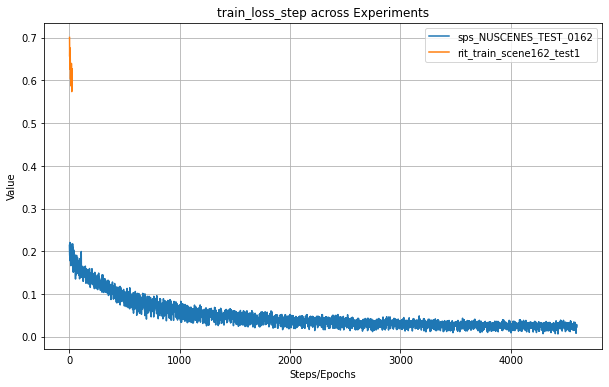

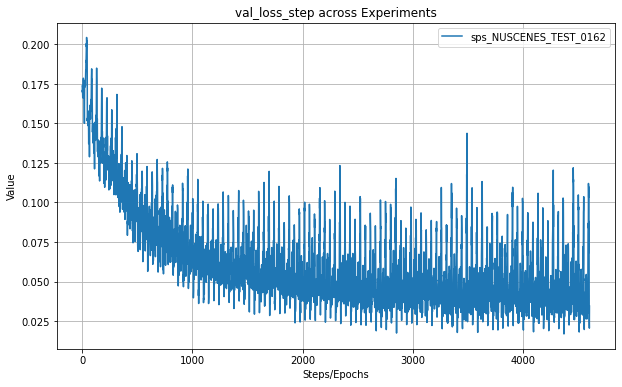

In [5]:
# standard_metrics = ['train_loss', 'val_loss', 'train_accuracy', 'val_accuracy', 'train_iou', 'val_iou']
standard_metrics = [
    'train_loss_step',
    'val_loss_step',
    'val_iou_unstable_epoch',
    'val_r2_epoch',
    # 'val_iou_stable_epoch',
]

# Instantiate the TensorBoardReader with the experiments list
reader = TensorBoardReader(experiments)

# Get the data (this will load data from all experiments)
metrics_data = reader.get_data()

# List available standardized metrics
print("Available standardized metrics:")
available_metrics = set()
for exp_name, exp_data in metrics_data.items():
    available_metrics.update(exp_data.keys())
print(available_metrics)

# Plot specific standardized metrics across experiments
metrics_to_plot = ['train_loss_step', 'val_loss_step']
reader.plot_metrics(metrics_to_plot, x_label='Steps/Epochs', y_label='Value')

### View per-scan predictions for a given scene

In [6]:
def plot_comparison_slider(scene_name, experiments, data_dir):
    """
    Plots an interactive slider to compare GT scans with labels and predictions from two experiments.
    Args:
    - scene_name (str): Name of the scene to process.
    - experiments (list): List containing two experiment dictionaries (one SPS and one RIT).
    - data_dir (str): Directory containing the dataset.
    """
    # Ensure we have exactly two experiments
    assert len(experiments) == 2, "Please provide exactly two experiments (one SPS and one RIT)."

    # Directories
    scans_dir = os.path.join(data_dir, 'sequence', scene_name, 'scans')
    labels_dir = os.path.join(data_dir, 'sequence', scene_name, 'labels')
    poses_dir = os.path.join(data_dir, 'sequence', scene_name, 'local_poses')

    # Get and sort filenames
    filenames = sorted([f for f in os.listdir(scans_dir) if f.endswith('.npy')],
                       key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', f.split('.npy')[0]))))

    # Load predictions from experiments
    pred_filenames_exp1 = [f for f in os.listdir(os.path.join(experiments[0]['prediction_dir'], scene_name, 'scans')) if f.endswith('.npy')]
    pred_filenames_exp1.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    pred_filenames_exp2 = [f for f in os.listdir(os.path.join(experiments[1]['prediction_dir'], scene_name)) if f.endswith('.npy')]
    pred_filenames_exp2.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    # Function to transform scan using pose
    def transform_doppler_points(transform, dpoints):
        result_dpoints = np.zeros_like(dpoints)
        points_h = np.ones((dpoints.shape[0], 4))
        points_h[:, :3] = dpoints[:, :3]
        points_h = (points_h @ transform.T)
        result_dpoints[:, :3] = points_h[:, :3]
        if dpoints.shape[1] > 3:
            result_dpoints[:, 3:] = dpoints[:, 3:]
        return result_dpoints

    # Color map for labels
    color_map = {
        0: np.array([0, 1, 0]).astype(float),  # Green for class 0
        1: np.array([1, 0, 0]).astype(float),  # Red for class 1
    }

    # Function to plot each frame
    def plot_frame(i):
        fig, axs = plt.subplots(1, 3, figsize=(24, 8))

        # GT Plot (First Column)
        scan = np.load(os.path.join(scans_dir, filenames[i]))
        labels = np.load(os.path.join(labels_dir, filenames[i]))
        labels = (labels <= 0.5).astype(int)  # Plotting for unstable
        pose = np.loadtxt(os.path.join(poses_dir, filenames[i].replace('.npy', '.txt')), delimiter=',')
        transformed_scan = transform_doppler_points(pose, scan)
        colors = [color_map[l] for l in labels]
        axs[0].scatter(transformed_scan[:, 0], transformed_scan[:, 1], c=colors, s=1)
        axs[0].set_title(f"Ground Truth ({scene_name}): {filenames[i]}")
        axs[0].set_xlabel('X')
        axs[0].set_ylabel('Y')

        # Experiment 1 (Second Column)
        exp1 = experiments[0]
        preds_exp1 = np.load(os.path.join(exp1['prediction_dir'], scene_name, 'scans', pred_filenames_exp1[i]))
        coords_exp1 = preds_exp1[:, :3]
        scores_exp1 = preds_exp1[:, -1]
        labels_exp1 = [int(s > exp1['threshold']) for s in scores_exp1]
        colors_exp1 = [color_map[l] for l in labels_exp1]
        axs[1].scatter(coords_exp1[:, 0], coords_exp1[:, 1], c=colors_exp1, s=1)
        axs[1].set_title(f"{exp1['name'].upper()}: {pred_filenames_exp1[i]}")
        axs[1].set_xlabel('X')
        axs[1].set_ylabel('Y')

        # Experiment 2 (Third Column)
        exp2 = experiments[1]
        preds_exp2 = np.load(os.path.join(exp2['prediction_dir'], scene_name, pred_filenames_exp2[i]))
        coords_exp2 = preds_exp2[:, :3]
        labels_exp2 = preds_exp2[:, -1].astype(int)
        colors_exp2 = [color_map[l] for l in labels_exp2]
        axs[2].scatter(coords_exp2[:, 0], coords_exp2[:, 1], c=colors_exp2, s=1)
        axs[2].set_title(f"{exp2['name'].upper()}: {pred_filenames_exp2[i]}")
        axs[2].set_xlabel('X')
        axs[2].set_ylabel('Y')

        plt.tight_layout()
        plt.show()
    
    # Create a slider widget to view different frames
    slider = IntSlider(min=0, max=len(filenames) - 1, step=1, description='Frame')
    interact(plot_frame, i=slider)

In [7]:
scene_name = 'scene-0162'
plot_comparison_slider(scene_name, experiments, data_dir)

interactive(children=(IntSlider(value=0, description='Frame', max=45), Output()), _dom_classes=('widget-intera…

### Get Quantitative Metrics

Processing sps (NUSCENES_TEST_0162) for scene scene-0162


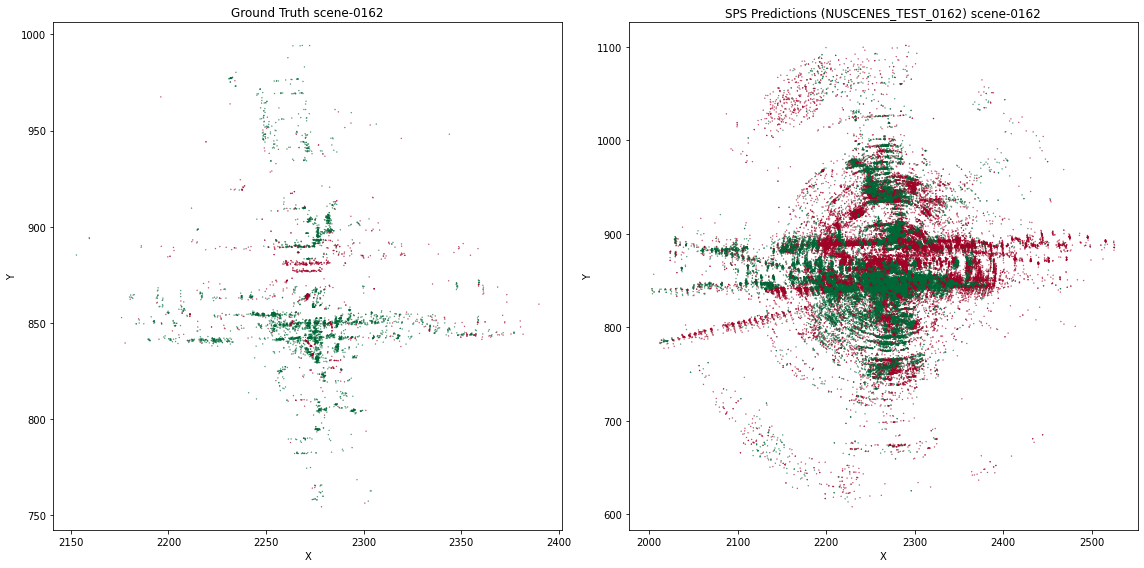

Processing rit (train_scene162_test1) for scene scene-0162


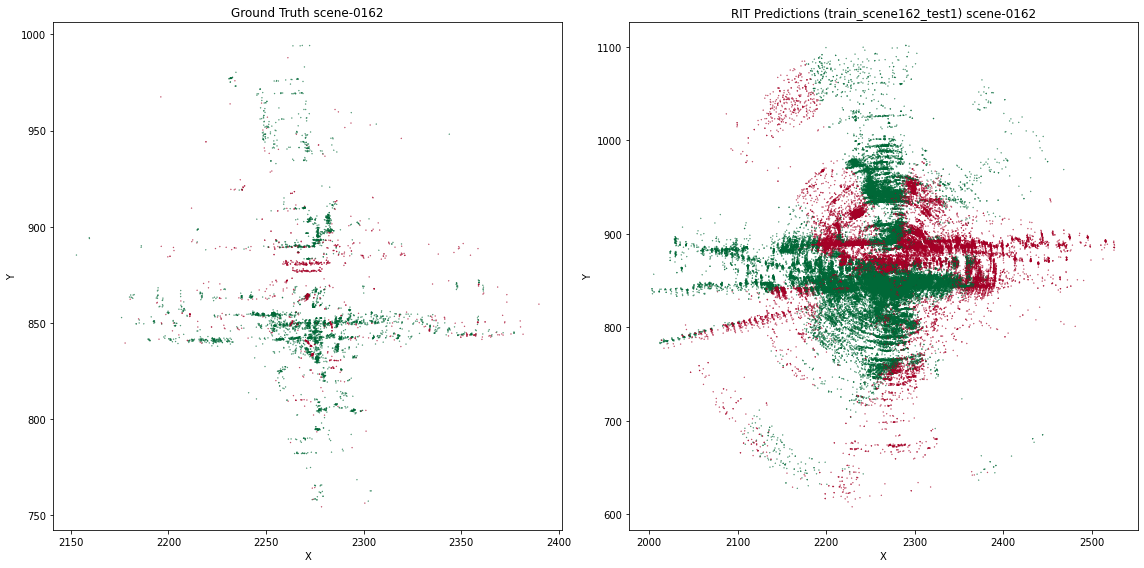

In [8]:
# Function to calculate metrics
def calculate_metrics(true_labels, predicted_labels):
    # Calculate True Positives, False Positives, False Negatives
    true_positives = np.sum(np.logical_and(true_labels == 1, predicted_labels == 1))
    true_negatives = np.sum(np.logical_and(true_labels == 0, predicted_labels == 0))
    false_positives = np.sum(np.logical_and(true_labels == 0, predicted_labels == 1))
    false_negatives = np.sum(np.logical_and(true_labels == 1, predicted_labels == 0))

    # Calculate Precision, Recall, and F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
    dIoU = true_positives / (true_positives + false_negatives + false_positives)

    return precision, recall, f1, accuracy, dIoU

# Function to compute IoU for point clouds
def compute_iou_pointcloud(output, target, num_classes, ignore_index=255):
    # Ensure output and target have the same shape
    assert output.shape == target.shape

    # Flatten output and target arrays if needed
    output = output.reshape(-1).copy()  # Make a copy to avoid modifying original data
    target = target.reshape(-1)

    # Mask out the ignored indices in the output
    output[target == ignore_index] = ignore_index

    # Compute intersection: where output equals target
    intersection = output[output == target]

    # Histogram binning to calculate the number of occurrences for each class
    area_intersection, _ = np.histogram(intersection, bins=np.arange(num_classes + 1))
    area_output, _ = np.histogram(output, bins=np.arange(num_classes + 1))
    area_target, _ = np.histogram(target, bins=np.arange(num_classes + 1))

    # Union is the sum of the target and predicted areas minus the intersection
    area_union = area_output + area_target - area_intersection

    # Compute IoU for each class: intersection over union
    iou_per_class = np.zeros(num_classes)
    for cls in range(num_classes):
        if area_union[cls] > 0:  # Avoid division by zero
            iou_per_class[cls] = area_intersection[cls] / area_union[cls]

    return iou_per_class

# Function to process a scene for a given experiment
def process_scene(experiment, scene_name, data_dir):
    exp_name = experiment['name']
    print(f"Processing {exp_name} ({experiment['exp_name']}) for scene {scene_name}")

    # Directories
    scans_dir = os.path.join(data_dir, 'sequence', scene_name, 'scans')
    labels_dir = os.path.join(data_dir, 'sequence', scene_name, 'labels')

    # Get ground truth scans and labels
    scan_files = sorted([os.path.join(scans_dir, file) for file in os.listdir(scans_dir) if file.endswith('.npy')], key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', os.path.basename(f).split('.npy')[0]))))
    gt_scans = [np.load(s) for s in scan_files]
    label_files = sorted([os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith('.npy')], key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', os.path.basename(f).split('.npy')[0]))))
    gt_labels = [1 - np.load(l) for l in label_files]  # Map unstable to 1 to compare with trained networks

    # Parse predictions
    if exp_name == 'sps':
        pred_map, pred_scans = parse_sps_predictions(dataset_dir=data_dir, predictions_dir=experiment['prediction_dir'], scene_name=scene_name)
    elif exp_name == 'rit':
        pred_map, pred_scans = parse_rit_predictions(dataset_dir=data_dir, predictions_dir=experiment['prediction_dir'], scene_name=scene_name)
    else:
        print(f"Experiment {exp_name} not recognized.")
        return None

    # Initialize metrics dictionary
    metrics = {
        "dIoU": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
        "Accuracy": [],
        'IoU_stable': [],
        'IoU_unstable': []
    }

    # Compute metrics for each scan
    for label, pred_scan in zip(gt_labels, pred_scans):
        gt = label.astype(int)
        pred = (pred_scan[:, -1] > experiment['threshold']).astype(int)
        precision, recall, f1, accuracy, dIoU = calculate_metrics(gt, pred)
        classwise_iou = compute_iou_pointcloud(pred, gt, 2)
        metrics['Precision'].append(precision)
        metrics['dIoU'].append(dIoU)
        metrics['Recall'].append(recall)
        metrics['F1'].append(f1)
        metrics['Accuracy'].append(accuracy)
        metrics['IoU_stable'].append(classwise_iou[0])
        metrics['IoU_unstable'].append(classwise_iou[1])

    # Compute average metrics for the scene
    avg_metrics = {}
    for metric_name, metric_values in metrics.items():
        mean_value = sum(metric_values) / len(metric_values)
        avg_metrics[metric_name] = mean_value

    # Save qualitative results
    gt_map = np.loadtxt(os.path.join(data_dir, "maps", f'{scene_name}.asc'), skiprows=1)
    pred_map[:, -1] = 1 - pred_map[:, -1]  # Map labels to match ground truth
    plot_predicted_map(gt_map, pred_map, scene_name, experiment['name'], experiment['exp_name'])

    # Save predicted map
    output_file = os.path.join(experiment['output_dir'], f'{scene_name}.asc')
    np.savetxt(output_file, pred_map, fmt='%.6f', delimiter=' ', header='x y z stable_prob', comments='')

    return avg_metrics

# Function to parse RIT predictions
def parse_rit_predictions(dataset_dir, predictions_dir, scene_name):
    src_pose_dir = os.path.join(dataset_dir, 'sequence', scene_name, 'local_poses')
    dst_pose_dir = os.path.join(dataset_dir, 'sequence', scene_name, 'poses')
    scans_dir = os.path.join(dataset_dir, 'sequence', scene_name, 'scans')

    scan_files = sorted([os.path.join(scans_dir, file) for file in os.listdir(scans_dir) if file.endswith('.npy')], key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', f.split('.npy')[0]))))
    src_pose_paths = sorted([os.path.join(src_pose_dir, file) for file in os.listdir(src_pose_dir) if file.endswith('.txt')], key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', f.split('.txt')[0]))))
    dst_pose_paths = sorted([os.path.join(dst_pose_dir, file) for file in os.listdir(dst_pose_dir) if file.endswith('.txt')], key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', f.split('.txt')[0]))))

    src_poses = [np.loadtxt(pth, delimiter=',') for pth in src_pose_paths]
    dst_poses = [np.loadtxt(pth, delimiter=',') for pth in dst_pose_paths]

    all_scans = []
    for i, scan_file in enumerate(scan_files):
        predicted_pcl = np.load(os.path.join(predictions_dir, scene_name, f'{i}.npy'))
        global_predicted_pcl = update_pointcloud_pose(predicted_pcl, src_poses[i], dst_poses[i])
        all_scans.append(global_predicted_pcl)

    output_map = np.vstack(all_scans)
    return output_map, all_scans

# Function to parse SPS predictions
def parse_sps_predictions(dataset_dir, predictions_dir, scene_name):
    scans_dir = os.path.join(dataset_dir, 'sequence', scene_name, 'scans')
    scan_files = sorted([os.path.join(scans_dir, file) for file in os.listdir(scans_dir) if file.endswith('.npy')], key=lambda f: float(''.join(filter(lambda x: x.isdigit() or x == '.', f.split('.npy')[0]))))
    all_scans = []
    for i, scan_file in enumerate(scan_files):
        predicted_pcl = np.load(os.path.join(predictions_dir, scene_name, 'scans', f'{i}.npy'))[:, [0, 1, 2, 4]]
        all_scans.append(predicted_pcl)

    output_map = np.vstack(all_scans)
    return output_map, all_scans

# Function to update point cloud pose
def update_pointcloud_pose(pointcloud, from_pose, to_pose):
    transformation = to_pose @ np.linalg.inv(from_pose)
    NP = pointcloud.shape[0]
    xyz = pointcloud[:, :3]
    labels = pointcloud[:, 3].reshape(NP, 1)
    xyz1 = np.hstack([xyz, np.ones((NP, 1))]).T
    transformed_xyz = (transformation @ xyz1).T[:, :3]
    transformed_point_clouds = np.hstack([transformed_xyz, labels])
    return transformed_point_clouds

# Function to plot predicted map
def plot_predicted_map(gt_pcl, pred_pcl, scene_name, model_name, exp_name):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    gt_labels = [int(s > 0.5) for s in gt_pcl[:, -1]]
    axes[0].scatter(gt_pcl[:, 0], gt_pcl[:, 1], c=gt_labels, cmap='RdYlGn', s=0.1)
    axes[0].set_title(f'Ground Truth {scene_name}')
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')

    pred_labels = [int(s > 0.5) for s in pred_pcl[:, -1]]
    axes[1].scatter(pred_pcl[:, 0], pred_pcl[:, 1], c=pred_labels, cmap='RdYlGn', s=0.1)
    axes[1].set_title(f'{model_name.upper()} Predictions ({exp_name}) {scene_name}')
    axes[1].set_xlabel('X')
    axes[1].set_ylabel('Y')

    plt.tight_layout()
    plt.show()

# Main processing loop
for experiment in experiments:
    per_scene_metrics = []

    for scene_name in test_scenes:
        avg_metrics = process_scene(experiment, scene_name, data_dir)
        if avg_metrics is not None:
            per_scene_metrics.append(avg_metrics)

    # Average metrics over scenes
    if per_scene_metrics:
        overall_avg_metrics = {}
        for metric_name in per_scene_metrics[0].keys():
            overall_avg_metrics[metric_name] = np.mean([metrics[metric_name] for metrics in per_scene_metrics])
        overall_avg_metrics['Model'] = experiment['name']
        overall_avg_metrics['Experiment'] = experiment['exp_name']
        metrics_df = metrics_df.append(overall_avg_metrics, ignore_index=True)

In [9]:
# Display the metrics DataFrame
metrics_df = metrics_df[['Model', 'Experiment', 'IoU_stable', 'IoU_unstable', 'dIoU', 'Precision', 'Recall', 'F1', 'Accuracy']]
metrics_df

,Model,Experiment,IoU_stable,IoU_unstable,dIoU,Precision,Recall,F1,Accuracy
0,sps,NUSCENES_TEST_0162,0.885938,0.762727,0.762727,0.957211,0.78891,0.863485,0.916599
1,rit,train_scene162_test1,0.754834,0.539851,0.539851,0.749015,0.65714,0.695828,0.811956


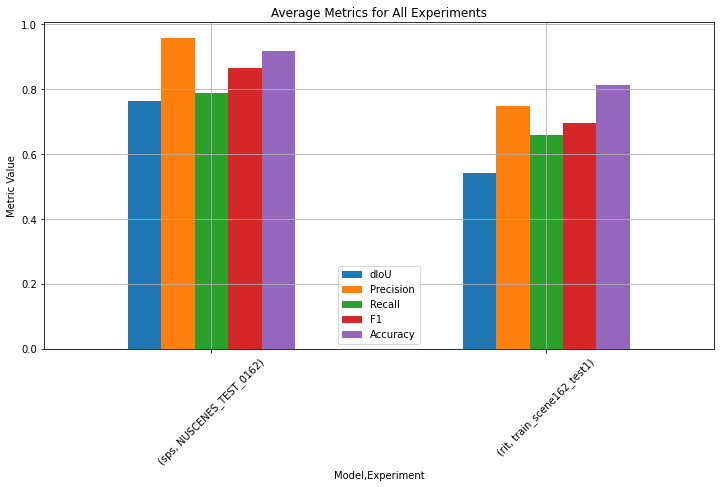

In [10]:
# Plotting the average metrics for all experiments
metrics_to_plot = ['dIoU', 'Precision', 'Recall', 'F1', 'Accuracy']
metrics_df.set_index(['Model', 'Experiment'])[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
plt.title('Average Metrics for All Experiments')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.grid(True)
plt.show()